In [34]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf
from tqdm import tqdm
import glob
import scipy.misc
import math
import sys

import skimage
from skimage import data, color, exposure
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
MODEL_DIR = '/tmp/imagenet'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
softmax = None

In [4]:
# Call this function with list of images. Each of elements should be a 
# numpy array with values ranging from 0 to 255.
def get_inception_score(images, splits=10):
    assert(type(images) == list)
    assert(type(images[0]) == np.ndarray)
    #assert(len(images[0].shape) == 3)
    #assert(np.max(images[0]) > 10)
    #assert(np.min(images[0]) >= 0.0)
    inps = []
    for img in images:
        img = img.astype(np.float32)
        inps.append(np.expand_dims(img, 0))
    bs = 100
    with tf.Session() as sess:
        preds = []
        n_batches = int(math.ceil(float(len(inps)) / float(bs)))
        for i in range(n_batches):
            sys.stdout.write(".")
            sys.stdout.flush()
            inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
            inp = np.concatenate(inp, 0)
            pred = sess.run(softmax, {'ExpandDims:0': inp})
            preds.append(pred)
        preds = np.concatenate(preds, 0)
        scores = []
        for i in range(splits):
            part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
            kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
            kl = np.mean(np.sum(kl, 1))
            scores.append(np.exp(kl))
        return np.mean(scores), np.std(scores)

In [5]:
# This function is called automatically.
def _init_inception():
    global softmax
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(MODEL_DIR, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (
                filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(MODEL_DIR)
    with tf.gfile.FastGFile(os.path.join(
        MODEL_DIR, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
    # Works with an arbitrary minibatch size.
    with tf.Session() as sess:
        pool3 = sess.graph.get_tensor_by_name('pool_3:0')
        ops = pool3.graph.get_operations()
        for op_idx, op in enumerate(ops):
            for o in op.outputs:
                shape = o.get_shape()
                shape = [s.value for s in shape]
                new_shape = []
                for j, s in enumerate(shape):
                    if s == 1 and j == 0:
                        new_shape.append(None)
                    else:
                        new_shape.append(s)
                o._shape = tf.TensorShape(new_shape)
        w = sess.graph.get_operation_by_name("softmax/logits/MatMul").inputs[1]
        logits = tf.matmul(tf.squeeze(pool3), w)
        softmax = tf.nn.softmax(logits)

In [6]:
_init_inception()

## Import CIFAR10 dataset to get the Inception Score

In [13]:
X_cifar10  = []

cifar10_imgs = glob.glob("./cifar10_inception_score_samples/*.png")

  0%|                                                  | 0/121 [00:00<?, ?it/s]C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|███████████████████████████████████████| 121/121 [00:00<00:00, 139.70it/s]


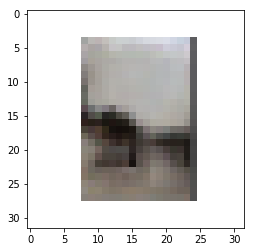

In [14]:
# load CIFAR10 sample images
for img in tqdm(cifar10_imgs):
    img = skimage.io.imread(img)[:, :, :3]
    X_cifar10.append(resize(img, (32, 32, 3)))
    
plt.imshow(X_cifar10[0])

## Evaluation

In [22]:
# cifar10 inception score (mean, standard dev)
get_inception_score(X_cifar10[:-60], 10)

.

(1.0015844, 0.00045226174)